In [48]:
import numpy as np
#import numpy.ma as ma
from uncertainties import ufloat, unumpy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

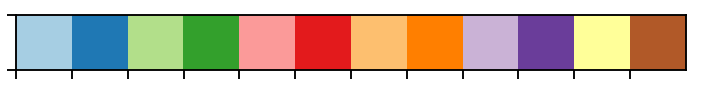

In [49]:
sns.set_context('talk')
sns.palplot(sns.color_palette("Paired"))

# Constants

In [50]:
C = 299792458 # Speed of light in [m/s]
H = ufloat(6.626070040E-34, 0.000000081E-34) # Planck's constant [Js]
HBAR = H/(2*np.pi) # Planck's constant [Js]
KB = ufloat(1.38064852E-23, 0.00000079E-23) # Boltzmann constant [J/K]

# Functions

In [51]:
# Trap power lock without additional attenuators
def power_lock_trap(V):
    # Linear fit slope
    m = ufloat(258.915611, 0.66058672)
    
    # Linear fit intercept
    b = ufloat(78.0872501, 2.84702705)
    
    # Returns power in [uW]
    return m*V + b

def power_lock_trap_ND513A(V):
    # Linear fit slope
    m = ufloat(14.1992971, 0.01643145)
    
    # Linear fit intercept
    b = ufloat(4.41319911, 0.08775840)
    
    # Returns power in [uW]
    return m*V + b

# Lifetime plot

In [52]:
# No dimple lifetime
lifetime_no_dimple = np.mean([ufloat(12.968, 0.609), ufloat(11.877, 0.658), ufloat(13.832, 1.021)])
lifetime_no_dimple_avg = lifetime_no_dimple.nominal_value
lifetime_no_dimple_std = lifetime_no_dimple.std_dev

In [53]:
data = pd.read_excel('dimple_84Sr-measurements.xlsx', sheet_name='Lifetime')

data['Power'] = 0
for idx, row in data.iterrows():
    P = 0
    V = row['Dimple set point [V]']
    if row['ND513A?']:
        P = power_lock_trap_ND513A(V)
    
    elif ~row['ND513A?']:
        P = power_lock_trap(V)
        
    else:
        print('Error!')
    
    data.at[idx,'Power'] = P

data['Power_avg'] = unumpy.nominal_values(data['Power'])
data['Power_unc'] = unumpy.std_devs(data['Power'])

data.drop(columns='Power', inplace=True)

In [54]:
data_agg = data.groupby(by=['Power_avg'], as_index=False).agg({'Power_unc':['first'],
                                                               'Lifetime [s]':[np.mean, np.std]})

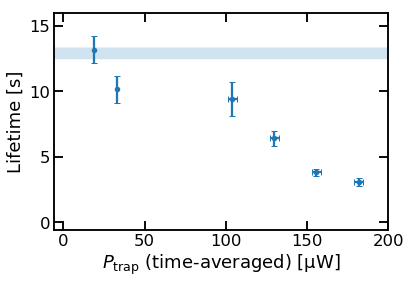

In [108]:
x_no_dimple = np.linspace(-10, 200, 1000)

# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = data_agg['Lifetime [s]','mean']
yerr = data_agg['Lifetime [s]','std']

plt.figure(figsize=(6,4))
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, fmt='.', capsize=3)

plt.fill_between(x_no_dimple,
                 lifetime_no_dimple_avg+lifetime_no_dimple_std,
                 lifetime_no_dimple_avg-lifetime_no_dimple_std,
                 alpha=0.2)

# Tick settings
ax = plt.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',direction='in')

# Axis limits
plt.xlim((-6, 200))
plt.ylim((-0.6, 16))

# Axes labels
plt.xlabel(r'$P_{\rm{trap}}$ (time-averaged) [$\rm{{\mu}W}$]')
plt.ylabel(r'Lifetime [s]')

plt.savefig('dimple-84Sr_lifetime.svg', bbox_inches='tight')
plt.show()

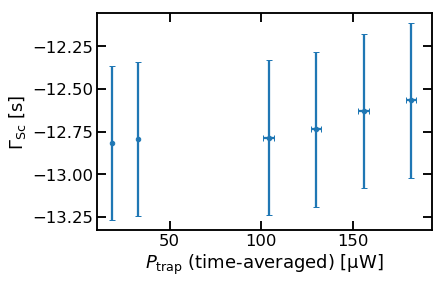

In [96]:
# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = data_agg['Lifetime [s]','mean']
yerr = data_agg['Lifetime [s]','std']

tau_total = unumpy.uarray(ydata, yerr)
tau_bg = 1/lifetime_no_dimple

G_sc = 1/tau_total - 1/tau_bg

x_no_dimple = np.linspace(0, 200)

# Measured dimple lifetime
xdata = data_agg['Power_avg']
xerr = data_agg['Power_unc','first']

ydata = unumpy.nominal_values(G_sc)
yerr = unumpy.std_devs(G_sc)

plt.figure()
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, fmt='.', capsize=3)

# Tick settings
ax = plt.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis='both',direction='in')

# Axes labels
plt.xlabel(r'$P_{\rm{trap}}$ (time-averaged) [$\rm{{\mu}W}$]')
plt.ylabel(r'$\Gamma_{\rm{Sc}}$ [s]')

plt.show()